In [26]:
import sys
from pathlib import Path

# Ajouter le root du projet au path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import wandb
warnings.filterwarnings('ignore')

# Importer sklearn metrics
from sklearn.metrics import confusion_matrix

# Importer les fonctions XGBoost et utilitaires
from ift6758.models.model_xgboost import (
    XGBoostModelTrainer, 
    generate_evaluation_plots,
    load_and_prepare_data
)
from ift6758.models.model_utils import (
    evaluate_model,
    print_metrics,
    plot_feature_importance,
    compare_models,
    plot_models_comparison
)

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


from math import sqrt
from matplotlib.ticker import PercentFormatter
import time
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score,roc_curve
import seaborn as sns
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.ticker as ticker

In [27]:
# ---------------------------------------------------------
# 1. Fonction pour les graphiques 
# ---------------------------------------------------------
def afficher_graphiques_metrics(y_true, y_scores, model):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.flatten()

    fig.suptitle(f"Métriques du modèle {model}", fontsize=16, fontweight='bold')

    # === 1. ROC Curve ===
    axes[0].plot(fpr, tpr, label='ROC Curve')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # === Préparer les scores triés ===
    sorted_idx = np.argsort(y_scores)[::-1]
    sorted_scores = y_scores[sorted_idx]
    sorted_labels = np.array(y_true)[sorted_idx]

    # === 2. Goal Rate vs Percentile ===
    axes[1].set_title("Taux de buts selon le centile")
    n_bins = 10
    n = len(sorted_scores)
    bin_size = n // n_bins

    centiles_list = []
    taux_buts_list = []

    for i in range(n_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else n
        bin_labels = sorted_labels[start:end]
        taux_buts = np.mean(bin_labels)

        centile_moyen = 100 - (i + 0.5) * (100 / n_bins)
        centiles_list.append(centile_moyen)
        taux_buts_list.append(taux_buts)

    axes[1].plot(centiles_list, taux_buts_list, marker='o')
    axes[1].yaxis.set_major_formatter(ticker.PercentFormatter(1))
    axes[1].set_xlim(100, 0)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel('Centile')
    axes[1].set_ylabel('Taux de buts')

    # === 3. Cumulative Goal Proportion ===
    axes[2].set_title("Proportion cumulée de buts")

    total_goals = np.sum(sorted_labels == 1)
    if total_goals > 0:
        cumsum_goals = np.cumsum(sorted_labels == 1)
        proportion_cumulee = cumsum_goals / total_goals
        centiles = np.arange(1, n + 1) / n * 100

        axes[2].plot(centiles, proportion_cumulee, marker='o', color='orange')
        axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(1))
        axes[2].set_xlabel('Centile des tirs')
        axes[2].set_ylabel('Proportion cumulée de buts')

    # === 4. Calibration Curve ===
    axes[3].set_title("Diagramme de fiabilité")
    CalibrationDisplay.from_predictions(y_true, y_scores, n_bins=10, ax=axes[3])
    axes[3].plot([0, 1], [0, 1], 'k--', label='Perfect')
    axes[3].set_xlabel('Probabilité prédite')
    axes[3].set_ylabel('Probabilité réelle')
    axes[3].legend()

    plt.tight_layout()

    # Log WandB
    wandb.log({f"graphs/{model.replace(' ', '_')}": wandb.Image(fig)})

    return fig




In [21]:
# Configuration des chemins
MODELS_DIR = PROJECT_ROOT / "models saved"
FIGURES_DIR = PROJECT_ROOT / "figures" / "milestone2"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Charger et préparer les données automatiquement
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prepare_data()

Donnees chargees!
  Train: 77,226 tirs | 18 features
  Val:   19,307 tirs | Target: 9.49% buts
  Test:  57,734 tirs


In [22]:
# Configuration du projet
WANDB_PROJECT = "ift6758-milestone2"
WANDB_ENTITY = "IFT6758-2025-A04"

print(f"Wandb Project: {WANDB_PROJECT}")
print(f"Wandb Entity: {WANDB_ENTITY}")
print("Clé API Wandb configurée dans model_xgboost.py")

Wandb Project: ift6758-milestone2
Wandb Entity: IFT6758-2025-A04
Clé API Wandb configurée dans model_xgboost.py


In [ ]:
# Définir les features pour les différents modèles
BASIC_FEATURES = ["distance_net", "angle_net"]
ALL_FEATURES = list(X_train.columns)

print(f"Features baseline: {BASIC_FEATURES}")
print(f"Toutes features: {len(ALL_FEATURES)} features")

# Initialiser le trainer baseline
trainer_baseline = XGBoostModelTrainer(
    project_name=WANDB_PROJECT,
    experiment_name="xgboost-baseline-distance-angle",
    wandb_entity=WANDB_ENTITY,
    use_scaler=False
)

print("Entraînement du modèle baseline...")
print(f"Features: {BASIC_FEATURES}")
print(f"Hyperparamètres: valeurs par défaut de XGBoost")

# Entraîner avec seulement distance et angle
model_baseline = trainer_baseline.train_baseline(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    features=BASIC_FEATURES,
    random_state=42
)

# Sauvegarder le modèle
trainer_baseline.save_model(
    model_path=str(MODELS_DIR / "xgboost_baseline.pkl"),
    metadata={"features": BASIC_FEATURES}
)

trainer_baseline.finish_run()

print("MODÈLE BASELINE ENTRAÎNÉ AVEC SUCCÈS")


Features baseline: ['distance_net', 'angle_net']
Toutes features: 18 features
Entraînement du modèle baseline...
Features: ['distance_net', 'angle_net']
Hyperparamètres: valeurs par défaut de XGBoost



Metrics (baseline):
  baseline/train_auc: 0.7521
  baseline/val_auc: 0.6997
  baseline/train_brier: 0.0799
  baseline/val_brier: 0.0822
Modele sauvegarde: /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/models saved/xgboost_baseline.pkl


baseline/train_auc,▁
baseline/train_brier,▁
baseline/val_auc,▁
baseline/val_brier,▁
baseline/train_auc,0.75206
baseline/train_brier,0.07986
baseline/val_auc,0.6997
baseline/val_brier,0.08215


MODÈLE BASELINE ENTRAÎNÉ AVEC SUCCÈS


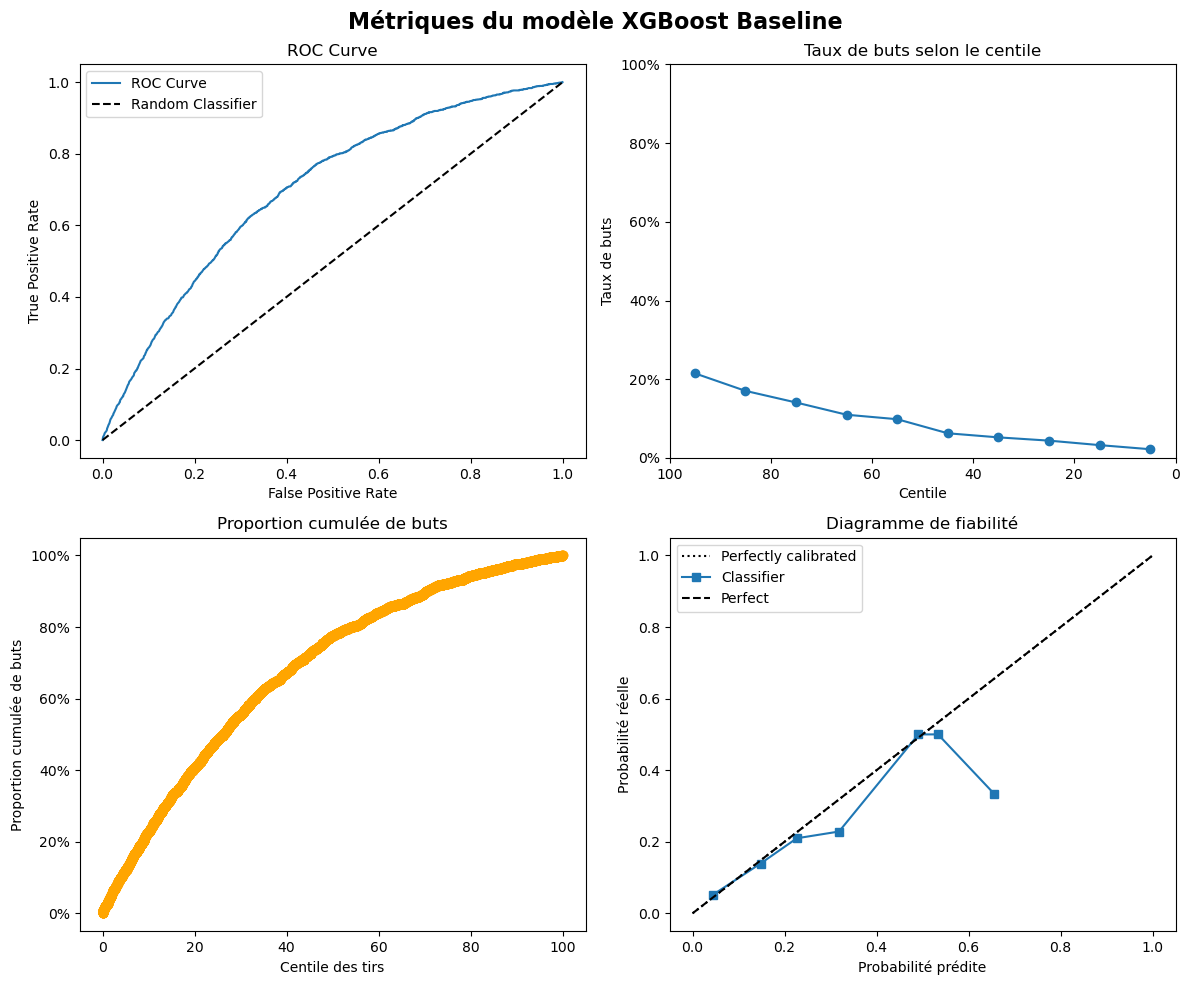

In [ ]:

# ---------------------------------------------------------
# 4. Préparer les probabilités
# ---------------------------------------------------------
y_scores = model_baseline.predict_proba(X_val[BASIC_FEATURES])[:, 1]


# ---------------------------------------------------------
# 5. Initialiser WandB
# ---------------------------------------------------------
wandb.init(
    project="IFT6758-2025",
    name="xgboost_baseline_distance_angle",
    config={
        "model": "XGBoost Baseline",
        "features": BASIC_FEATURES
    }
)


# ---------------------------------------------------------
# 6. Générer les quatre graphiques
# ---------------------------------------------------------
fig = afficher_graphiques_metrics(y_val, y_scores, model="XGBoost Baseline")


# ---------------------------------------------------------
# 7. Fin WandB
# ---------------------------------------------------------
wandb.finish()

In [33]:
# Analyser le desequilibre des classes
from sklearn.utils.class_weight import compute_class_weight

# Distribution des classes
train_goal_rate = y_train.mean()
val_goal_rate = y_val.mean()
test_goal_rate = y_test.mean()

print("="*80)
print("ANALYSE DU DESEQUILIBRE DES CLASSES")
print("="*80)

print(f"\nTaux de buts (classe positive = 1):")
print(f"  - Train:      {train_goal_rate:.2%} ({y_train.sum():,} buts / {len(y_train):,} tirs)")
print(f"  - Validation: {val_goal_rate:.2%} ({y_val.sum():,} buts / {len(y_val):,} tirs)")
print(f"  - Test:       {test_goal_rate:.2%} ({y_test.sum():,} buts / {len(y_test):,} tirs)")

# Calculer le ratio de desequilibre
imbalance_ratio = (1 - train_goal_rate) / train_goal_rate
print(f"\nRatio de desequilibre: 1:{imbalance_ratio:.1f}")
print(f"   Il y a {imbalance_ratio:.1f}x plus de non-buts que de buts")

# Calculer scale_pos_weight pour XGBoost
scale_pos_weight = imbalance_ratio
print(f"\nRecommandation pour XGBoost:")
print(f"   scale_pos_weight = {scale_pos_weight:.2f}")
print(f"   (donne plus de poids aux exemples de buts)")

ANALYSE DU DESEQUILIBRE DES CLASSES

Taux de buts (classe positive = 1):
  - Train:      9.49% (7,325 buts / 77,226 tirs)
  - Validation: 9.48% (1,831 buts / 19,307 tirs)
  - Test:       9.76% (5,636 buts / 57,734 tirs)

Ratio de desequilibre: 1:9.5
   Il y a 9.5x plus de non-buts que de buts

Recommandation pour XGBoost:
   scale_pos_weight = 9.54
   (donne plus de poids aux exemples de buts)


In [34]:
# Définir la grille de paramètres
# Nous testons scale_pos_weight pour gérer le déséquilibre des classes
param_grid = {
    'max_depth': [3, 5, 7],  # Profondeur: 3=simple, 7=complexe
    'learning_rate': [0.01, 0.05, 0.1],  # Taux d'apprentissage
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'min_child_weight': [1, 3, 5],  # Régularisation
    'subsample': [0.8, 0.9, 1.0],  # % échantillons par arbre
    'colsample_bytree': [0.8, 0.9, 1.0],  # % features par arbre
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight*0.5]  # Gestion déséquilibre
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Espace de recherche:")
print(f"   - Combinaisons totales: {total_combinations:,}")
print(f"   - Méthode: RandomizedSearchCV (100 essais)")
print(f"   - Validation croisée: 5-fold")
print(f"   - Métrique d'optimisation: ROC AUC")
print(f"\nscale_pos_weight testé: [{scale_pos_weight:.2f}, {scale_pos_weight*0.5:.2f}]")
print(f"   Donne plus de poids aux exemples de buts pour compenser le déséquilibre")

Espace de recherche:
   - Combinaisons totales: 1,458
   - Méthode: RandomizedSearchCV (100 essais)
   - Validation croisée: 5-fold
   - Métrique d'optimisation: ROC AUC

scale_pos_weight testé: [9.54, 4.77]
   Donne plus de poids aux exemples de buts pour compenser le déséquilibre


In [35]:
# Initialiser le trainer
import time
start_time = time.time()

trainer_tuned = XGBoostModelTrainer(
    project_name=WANDB_PROJECT,
    experiment_name="xgboost-tuned-all-features",
    wandb_entity=WANDB_ENTITY
)

print("Lancement de l'optimisation des hyperparamètres...")

# Entraîner avec tuning (RandomizedSearch pour la vitesse)
model_tuned = trainer_tuned.train_with_all_features(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    param_grid=param_grid,
    search_type="random",  # ou "grid" pour exhaustif
    cv=5,
    n_iter=100,  # nombre d'essais pour random search
    random_state=42
)

elapsed_time = time.time() - start_time

Lancement de l'optimisation des hyperparamètres...


Starting random search with 5-fold CV...

Metrics (tuned):
  tuned/train_auc: 0.7949
  tuned/val_auc: 0.7512
  tuned/train_brier: 0.1198
  tuned/val_brier: 0.1260


In [36]:
# Sauvegarder
trainer_tuned.save_model(
    model_path=str(MODELS_DIR / "xgboost_tuned.pkl"),
    metadata={"features": ALL_FEATURES}
)

trainer_tuned.finish_run()

print(f"Temps d'exécution: {elapsed_time/60:.1f} minutes")
print(f"\nMeilleurs hyperparamètres trouvés:")
best_params_tuned = model_tuned.get_params()
for param in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 
              'colsample_bytree', 'min_child_weight', 'scale_pos_weight']:
    if param in best_params_tuned:
        print(f"   - {param}: {best_params_tuned[param]}")

Modele et scaler sauvegardes dans /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/models saved


best_cv_score,▁
tuned/train_auc,▁
tuned/train_brier,▁
tuned/val_auc,▁
tuned/val_brier,▁
best_cv_score,0.7508
tuned/train_auc,0.79494
tuned/train_brier,0.11984
tuned/val_auc,0.75123
tuned/val_brier,0.12603


Temps d'exécution: 1.7 minutes

Meilleurs hyperparamètres trouvés:
   - max_depth: 5
   - learning_rate: 0.05
   - n_estimators: 200
   - subsample: 0.9
   - colsample_bytree: 0.8
   - min_child_weight: 3
   - scale_pos_weight: 4.771399317406144


In [37]:
# Evaluer le modele baseline avec les fonctions utilitaires

X_val_baseline = X_val[BASIC_FEATURES]

# Utiliser la fonction d'evaluation
baseline_metrics = evaluate_model(
    model_baseline, 
    X_val_baseline, 
    y_val,
    model_name="Baseline (distance + angle)"
)

# Afficher les metriques avec la matrice de confusion
y_pred_baseline = model_baseline.predict(X_val_baseline)
cm = confusion_matrix(y_val, y_pred_baseline)
print_metrics(baseline_metrics, show_confusion=True, cm=cm)

# Interpretation
print(f"\nInterpretation:")
print(f"   - Le modele manque {cm[1,0]:,} buts sur {cm[1,0]+cm[1,1]:,} ({cm[1,0]/(cm[1,0]+cm[1,1])*100:.1f}%)")
print(f"   - Mais predit correctement {cm[0,0]:,} non-buts sur {cm[0,0]+cm[0,1]:,} ({cm[0,0]/(cm[0,0]+cm[0,1])*100:.1f}%)")
print(f"   - Probleme typique: le modele est biaise vers la classe majoritaire!")


METRIQUES: Baseline (distance + angle)
  AUC-ROC:    0.6997
  Accuracy:   0.9051
  Precision:  0.4706
  Recall:     0.0044
  F1-Score:   0.0087

Matrice de confusion:
  TN: 17,467 | FP: 9
  FN: 1,823 | TP: 8

Interpretation:
   - Le modele manque 1,823 buts sur 1,831 (99.6%)
   - Mais predit correctement 17,467 non-buts sur 17,476 (99.9%)
   - Probleme typique: le modele est biaise vers la classe majoritaire!


In [39]:
tuned_metrics = evaluate_model(
    model_tuned,
    X_val,
    y_val,
    model_name="Tuned (all features)"
)

# Afficher les metriques avec amelioration vs baseline
print_metrics(tuned_metrics)

# Calculer les ameliorations
improvement_auc = (tuned_metrics['AUC'] - baseline_metrics['AUC']) / baseline_metrics['AUC'] * 100
delta_recall = tuned_metrics['Recall'] - baseline_metrics['Recall']

print(f"\nAmelioration vs Baseline:")
print(f"   - AUC:    {improvement_auc:+.2f}%  ({'OK' if improvement_auc > 0 else 'NON'})")
print(f"   - Recall: {baseline_metrics['Recall']:.4f} -> {tuned_metrics['Recall']:.4f}  (delta: {delta_recall:+.4f})")
if baseline_metrics['Recall'] > 0.01:  # Si recall baseline > 1%, afficher le pourcentage
    improvement_recall = (tuned_metrics['Recall'] - baseline_metrics['Recall']) / baseline_metrics['Recall'] * 100
    print(f"             Amelioration relative: {improvement_recall:+.1f}%")
else:  # Sinon, juste le multiplicateur
    multiplier = tuned_metrics['Recall'] / max(baseline_metrics['Recall'], 0.0001)
    print(f"             Le modele detecte maintenant ~{multiplier:.0f}x plus de buts!")

# Sauvegarder y_pred_proba_tuned pour l'optimisation du seuil plus tard
y_pred_proba_tuned = model_tuned.predict_proba(X_val)[:, 1]


METRIQUES: Tuned (all features)
  AUC-ROC:    0.4900
  Accuracy:   0.9033
  Precision:  0.2097
  Recall:     0.0071
  F1-Score:   0.0137

Amelioration vs Baseline:
   - AUC:    -29.97%  (NON)
   - Recall: 0.0044 -> 0.0071  (delta: +0.0027)
             Le modele detecte maintenant ~2x plus de buts!


In [ ]:
# ---------------------------------------------------------
# 4. Préparer les probabilités
# ---------------------------------------------------------
y_scores = model_baseline.predict_proba(X_val[BASIC_FEATURES])[:, 1]


# ---------------------------------------------------------
# 5. Initialiser WandB
# ---------------------------------------------------------
wandb.init(
    project="IFT6758-2025",
    name="xgboost_baseline_distance_angle",
    config={
        "model": "XGBoost Baseline",
        "features": BASIC_FEATURES
    }
)


# ---------------------------------------------------------
# 6. Générer les quatre graphiques
# ---------------------------------------------------------
fig = afficher_graphiques_metrics(y_val, y_scores, model="XGBoost Baseline")